# 13 Reverse Quantum Annealing with Portfolio Optimization Problem as an example

## ポートフォリオ最適化問題

## Reverse Quantum Annealingとは

## Open Jijにおける実装

実際に実装を行う前に、まずは実験用データの生成を行う。
論文[1]にある方法に従って、与えられた初期値を用いて、ブラウン運動によるチャートを生成する。

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Magic numbers to generate assets
rho = 0.1 # input uniform correlation
mu = 0.075 # expected value
sigma = 0.15 # volatility/standard error
r0 = 0.015 # no risk return

付録Aによって、各時刻においてチャートの運動は前の時刻の運動によって
$$
S(t_{n+1})=S(t_n)\exp(\mu-\frac{1}{2}\sigma^2)\Delta t + \sigma Z_n\sqrt{\Delta t}
$$
のように与えられる。ここの$Z_n$はcholesky分解で作られた一様相関行列$\rho$を従う多変量正規分布になる。

それを実行して適当にチャートをプロットして様子を確認する。全体として初期値から広がっていくが、一部銘柄が大きく上昇または降下するのも確認できる。

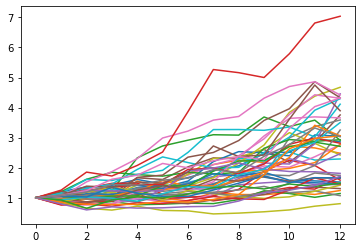

In [4]:
def createZvariables(N, rho):
  rho_mat = np.full((N,N), rho)
  rho_mat[range(N), range(N)] = 1.0
  rho_chole = np.linalg.cholesky(rho_mat)
  zNs_temp = np.random.normal(0, 1, (10000, N))
  zNs = zNs_temp @ rho_chole
  return zNs

def GetNextSt(St, mu, sigma, zN):
  Deltat = 1
  #zN = random.choice(zNs)
  scale = np.exp((mu-0.5*sigma*sigma)*Deltat + sigma*zN*np.sqrt(Deltat))
  NextSt = St * scale
  return NextSt

Nassets = 48
chart = list()
ZList = list()
Zvariables = createZvariables(Nassets, rho)
Zlabels = random.sample([x for x in range(10000)], 12)
for label in Zlabels:
  ZList.append(Zvariables[label])
for iasset in range(Nassets):
  chart_asset = [1.0]
  for month in range(12):
    chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
  chart.append(chart_asset)
  #print(chart_asset)
  plt.plot(list(range(13)), chart_asset)
plt.show()

銘柄のチャートを生成できたので、Sharpe Ratioを計算する。ここ結果を評価するに使うのは実現Sharpe Ratioで、無リスク利回り率を超過した超過収益率の平均と超過収益率の標準偏差で求められる。チャートを確認するとき分かったように、銘柄数が少ない場合は偶然による偏りが大きいので、銘柄を10回生成してその平均Shape Ratioの確認をする。
結果として、銘柄の平均Sharpe Ratioが概ね0.4付近になるのを確認できる。

In [5]:

def CreateAssets(Nassets): 
  chart = list()
  ZList = list()
  Zvariables = createZvariables(Nassets, rho)
  Zlabels = random.sample([x for x in range(10000)], 12)
  for label in Zlabels:
    ZList.append(Zvariables[label])
  for iasset in range(Nassets):
    chart_asset = [1.0]
    for month in range(12):
      chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
    chart.append(chart_asset)
  return chart

def CalculateSharpeRatio(asset):
  monthly_log_return = list()
  #monthly_return = list()
  for month in range(12):
    valueChange = asset[month+1]/asset[month] - 1.0 # 毎月の収益
    log_return = np.log(valueChange+1.0)
    monthly_log_return.append(log_return)
    #monthly_return.append(valueChange)

  mean_log_return = np.mean(monthly_log_return)
  log_volatility = np.std(monthly_log_return,ddof=1)

  #mean_return = np.mean(monthly_return)
  #volatility = np.std(monthly_return,ddof=1)


  return (mean_log_return-np.log(1+r0))/log_volatility
  #return (mean_return-r0)/volatility

allmean = 0
for ntry in range(10):
  Chart = CreateAssets(48)
  mean_SR = 0.0
  n = 0.
  for asset in Chart:
    assetSR = CalculateSharpeRatio(asset)
    mean_SR = ((mean_SR*n)+assetSR) / (n+1)
    n+=1
  print("SubSet "+ str(ntry)+ " average Sharpe Ratio: " + str(mean_SR))
  allmean = ((allmean*ntry)+mean_SR) / (ntry+1)
  print("Average Sharpe Ratio of all generated: "+ str(allmean))

SubSet 0 average Sharpe Ratio: 0.6100193564322
Average Sharpe Ratio of all generated: 0.6100193564322
SubSet 1 average Sharpe Ratio: 0.26054868907589773
Average Sharpe Ratio of all generated: 0.43528402275404887
SubSet 2 average Sharpe Ratio: 0.44699247188801544
Average Sharpe Ratio of all generated: 0.4391868391320377
SubSet 3 average Sharpe Ratio: 0.44888719351747725
Average Sharpe Ratio of all generated: 0.4416119277283976
SubSet 4 average Sharpe Ratio: 0.27326927219560515
Average Sharpe Ratio of all generated: 0.40794339662183904
SubSet 5 average Sharpe Ratio: 0.587534144211776
Average Sharpe Ratio of all generated: 0.43787518788682855
SubSet 6 average Sharpe Ratio: 0.29980231769278737
Average Sharpe Ratio of all generated: 0.41815049214482264
SubSet 7 average Sharpe Ratio: 0.3716710633847023
Average Sharpe Ratio of all generated: 0.41234056354980764
SubSet 8 average Sharpe Ratio: 0.31573263811179936
Average Sharpe Ratio of all generated: 0.40160634961225117
SubSet 9 average Sharpe

銘柄の確認ができてから、ポートフォリオを組んだ場合の確認を行う。論文に従い、大きな銘柄プールからある特定の数の銘柄をランダムに抽出してその実現Sharpe Ratioを計算する。
そのため、すでに作ってある関数で大きい銘柄数を持つ市場を生成する。

In [6]:
Nassets = 3826 #東証上場銘柄数 十分に大きければなんでも良いはず 
SizeOfPortfolio = 48

index_list = np.arange(Nassets)
Chart = CreateAssets(Nassets)

In [7]:
SR_list = list()
for ntry in range(100):
    selected_charts = list()
    choices = np.random.choice(index_list, size=SizeOfPortfolio, replace=False)
    chartSR_list = list()
    for ichart in choices:
        selected_charts.append(Chart[ichart])
        assetSR = CalculateSharpeRatio(Chart[ichart])
        chartSR_list.append(assetSR)
    print(np.min(chartSR_list),np.max(chartSR_list), np.mean(chartSR_list), np.percentile(chartSR_list, [25,75]))
    #print(np.mean(SR_list), np.percentile(SR_list, [25,75]))
    portfolioChart = np.mean(selected_charts, axis=0)
    print(portfolioChart)
    #print(portfolioChart)
    portfolioSR = CalculateSharpeRatio(portfolioChart)
    SR_list.append(portfolioSR)
    #plt.plot(list(range(13)), portfolioChart)
    #plt.show()
    #print(portfolioSR)
    #print(np.mean(SR_list), np.percentile(SR_list, [25,75]))


-0.5755324600062562 1.957226865987922 0.308405631415417 [0.05407817 0.39521163]
[1.         1.09153272 1.17542345 1.28240235 1.3170564  1.44550096
 1.5246351  1.64608218 1.71108936 1.81467626 1.92503604 2.05924182
 2.20847169]
-0.6355802545068153 1.457154328139606 0.3779282078057365 [0.21976463 0.55637788]
[1.         1.08328214 1.16758614 1.31572745 1.36942354 1.43493155
 1.54593587 1.68233103 1.76863921 1.82674461 1.98833671 2.15864386
 2.42404194]
-0.44429815903221137 1.8789117823117587 0.3247465396564995 [0.08351392 0.50175105]
[1.         1.10532132 1.17021301 1.27727476 1.3934558  1.50913518
 1.55150607 1.68974892 1.75696117 1.91001476 2.00011982 2.12637458
 2.33395509]
-0.34965822458973733 1.5700227199509373 0.3229401599441534 [0.17358799 0.44001104]
[1.         1.05414768 1.06514543 1.16263055 1.24766888 1.36135954
 1.46313525 1.55573074 1.61702936 1.757829   1.92582085 2.04760191
 2.19971481]
-0.18324724303120496 1.5571324498278505 0.38967253924398887 [0.16854931 0.59296503]
[

In [8]:
def SRBucket(SR_list):
    Buckets=sorted(SR_list)
    Buckets.reverse()
    GroupedList = list(np.array_split(Buckets,11))
    for i in range(len(SR_list)):
        if   SR_list[i] in GroupedList[0]: SR_list[i]=15
        elif SR_list[i] in GroupedList[1]: SR_list[i]=12
        elif SR_list[i] in GroupedList[2]: SR_list[i]=9
        elif SR_list[i] in GroupedList[3]: SR_list[i]=6
        elif SR_list[i] in GroupedList[4]: SR_list[i]=3
        elif SR_list[i] in GroupedList[5]: SR_list[i]=0
        elif SR_list[i] in GroupedList[6]: SR_list[i]=-3
        elif SR_list[i] in GroupedList[7]: SR_list[i]=-6
        elif SR_list[i] in GroupedList[8]: SR_list[i]=-9
        elif SR_list[i] in GroupedList[9]: SR_list[i]=-12
        elif SR_list[i] in GroupedList[10]: SR_list[i]=-15

def CorrelationBucket(Corr):
    for i in range(len(Corr)):
        for j in range(len(Corr)):
            if Corr[i][j] >= -1.00 and  Corr[i][j] < -0.25: Corr[i][j] = -5
            elif Corr[i][j] >= -0.25 and  Corr[i][j] < -0.15: Corr[i][j] = -3
            elif Corr[i][j] >= -0.15 and  Corr[i][j] < -0.05: Corr[i][j] = -1
            elif Corr[i][j] >= -0.05 and  Corr[i][j] < 0.05: Corr[i][j] = 0
            elif Corr[i][j] >= 0.05 and  Corr[i][j] < 0.15: Corr[i][j] = 1
            elif Corr[i][j] >= 0.15 and  Corr[i][j] < 0.25: Corr[i][j] = 3
            elif Corr[i][j] >= 0.25 and  Corr[i][j] < 1.00: Corr[i][j] = 5

def hi(SR_list, Corr, i):
    h = 0.5*SR_list[i] + np.sum(Corr[i])
    return h

def jij(Corr, i, j):
    return 1./4.*Corr[i][j]


In [9]:
import heapq


NassetsList = [48]#, 30, 36, 42, 48, 54, 60]

for Nassets in NassetsList:
    Solution = np.full(Nassets, -1)

    #相関係数などの準備
    Chart = CreateAssets(Nassets)
    CoeffMat = np.corrcoef(Chart)
    SR_list = list()
    for asset in Chart:
        SR_list.append(CalculateSharpeRatio(asset))

    #Bucketの翻訳
    SRBucket(SR_list)
    CorrelationBucket(CoeffMat)

    print(SR_list, CoeffMat)
    #Greedy Search
    Energies = list()
    for i in range(Nassets):
        h = hi(SR_list, CoeffMat, i)
        energyTuple = [-1*abs(h), h , i]
        Energies.append(energyTuple)
    heapq.heapify(Energies)
    
    ntry = 0
    print(Energies)
    while(ntry < len(Energies)):
        x, e, i = heapq.heappop(Energies)
        if e > 0:
            Solution[i] = -1.
        else:
            Solution[i] = 1.
        for ie in Energies:
            n = ie[2]
            ie[1] = ie[1] + Solution[i]*(jij(CoeffMat, i, n) + jij(CoeffMat, n, i))
            ie[0] = -ie[1]
        ntry+=1
    #heapq.heapify(Energies)
    print(Solution)

    #Genetic Algorithm
    

    

[-3, -6, 6, 6, 12, 15, 15, 3, -15, -12, -15, 6, -9, -12, 15, 12, -15, 3, -12, 0, -3, -15, 3, -6, -3, 6, 9, 0, 0, 6, -6, -9, -9, 9, 0, 15, -12, 12, 9, -6, 12, 9, 12, 15, -9, -3, 3, 9] [[1. 5. 5. ... 5. 5. 5.]
 [5. 1. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 ...
 [5. 5. 5. ... 1. 5. 5.]
 [5. 5. 5. ... 5. 1. 5.]
 [5. 5. 5. ... 5. 5. 1.]]
[[-225.0, 225.0, 4], [-222.5, 222.5, 35], [-222.5, 222.5, 26], [-218.0, 218.0, 15], [-222.0, 222.0, 40], [-218.5, 218.5, 5], [-221.5, 221.5, 14], [-215.5, 215.5, 7], [-217.0, 217.0, 3], [-216.5, 216.5, 20], [-216.5, 216.5, 46], [-217.0, 217.0, 11], [-216.0, 216.0, 2], [-210.0, 210.0, 27], [-217.5, 217.5, 6], [-212.5, 212.5, 32], [-213.5, 213.5, 33], [-204.0, 204.0, 36], [-215.0, 215.0, 37], [-214.0, 214.0, 19], [-215.5, 215.5, 41], [-205.5, 205.5, 43], [-204.5, 204.5, 22], [-212.5, 212.5, 47], [-155.5, 155.5, 24], [-211.0, 211.0, 25], [-194.5, 194.5, 12], [-113.0, 113.0, 13], [-209.0, 209.0, 28], [-202.0, 202.0, 29], [-213.0, 213.0, 30], [-204.5, 204.5,

### 普通のQuantum Annealingの解法

先ほど作っていたIsingをそのままQUBOに落としてこんで量子アニーリングのシミュレーターで動かしてみる。

<class 'numpy.ndarray'>


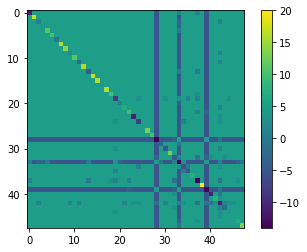

[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], -122., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], -122., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], -122., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], -122., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], -122., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], -122., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [33]:
from openjij import SQASampler
sampler = SQASampler()

NassetsList = [48]#, 30, 36, 42, 48, 54, 60]

for Nassets in NassetsList:
    Solution = np.full(Nassets, -1)

    #相関係数などの準備
    Chart = CreateAssets(Nassets)
    CoeffMat = np.corrcoef(Chart)
    SR_list = list()
    for asset in Chart:
        SR_list.append(CalculateSharpeRatio(asset))

    #Bucketの翻訳
    SRBucket(SR_list)
    CorrelationBucket(CoeffMat)


    QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
    for i in  range(Nassets):
        for j in range(Nassets):
            QUBO[i][j] = CoeffMat[i][j]
    for i in range(Nassets):
        QUBO[i][i] = QUBO[i][i] + SR_list[i]
    
    print(type(QUBO))
    import matplotlib.pyplot as plt
    plt.imshow(QUBO)
    plt.colorbar()
    plt.show()

    sampleset = sampler.sample_qubo(QUBO,num_reads=10)
    print(sampleset.record)



### Reverse Quantum Annealingの場合

<class 'numpy.ndarray'>


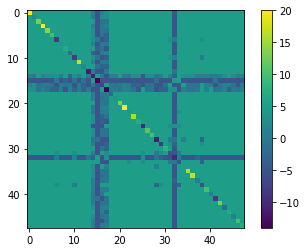

[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], -146., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], -146., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], -146., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], -146., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], -146., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], -146., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1

In [91]:
from openjij import SQASampler
sampler = SQASampler()

NassetsList = [48]#, 30, 36, 42, 48, 54, 60]


# RQA schedule
#timing = (0,1,2,3)
#Ratio = (1.0,0.38,0.38,1.0)
#schedule = list(zip(timing,Ratio))
#plt.plot(t,s)
#plt.show()

schedule = [
    [0.0, 0.4, 3],
    [0.33, 0.1, 3],
    [0.66, 0.1, 3],
    [1.0, 1.0, 3]
]

for Nassets in NassetsList:
    Solution = np.full(Nassets, -1)

    #相関係数などの準備
    Chart = CreateAssets(Nassets)
    CoeffMat = np.corrcoef(Chart)
    SR_list = list()
    for asset in Chart:
        SR_list.append(CalculateSharpeRatio(asset))

    #Bucketの翻訳
    SRBucket(SR_list)
    CorrelationBucket(CoeffMat)


    QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
    for i in  range(Nassets):
        for j in range(Nassets):
            QUBO[i][j] = CoeffMat[i][j]
    for i in range(Nassets):
        QUBO[i][i] = QUBO[i][i] + SR_list[i]
    
    print(type(QUBO))
    import matplotlib.pyplot as plt
    plt.imshow(QUBO)
    plt.colorbar()
    plt.show()

    sampleset = sampler.sample_qubo(QUBO,num_reads=10)
    print(sampleset.record)

    init_state = sampleset.record[-1][0]
    sampleset_RQA = sampler.sample_qubo(QUBO,num_reads=10, schedule=schedule, initial_state = init_state)
    print(sampleset_RQA.record)


## 参考文献
1. Davide Venturelli, Alexei Kondratyev, "Reverse Quantum Annealing Approach to Portfolio Optimization Problems", Quantum Machine Intelligence volume 1, pages17–30 (2019)